In [3]:
import pandas as pd
import re
from transformers import pipeline
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the CSV file
file_path = '/content/tweets.csv'
data = pd.read_csv(file_path)

In [5]:
# Display first few rows to understand the structure
print("Data Preview:")
print(data.head())

Data Preview:
      tweet_id                       date  \
0  1.47058E+18  2021-12-14 02:36:09+00:00   
1  1.47058E+18  2021-12-14 02:35:54+00:00   
2  1.47058E+18  2021-12-14 02:35:45+00:00   
3  1.47058E+18  2021-12-14 02:35:44+00:00   
4  1.47058E+18  2021-12-14 02:35:10+00:00   

                                                text       user_name  \
0  I've avoided a hot take on the log4j situation...      Matt Klein   
1  @RSnake Right? Whoever started calling it log4...  George Furbish   
2  @jobertabma @Hacker0x01 Please give insight fo...  Abdillah Hasny   
3  I was just talking about the impact of this vu...   Cimone Wright   
4  Is it me or did the Internet miss a golden opp...   Robert Hansen   

  user_location                                   user_description  \
0         Idaho  Plumber @lyft. @envoyproxy creator. CNCF GB. H...   
1      NYC, USA  Physics PhD candidate studying complex systems...   
2     Indonesia  https://t.co/GJ0x1ASxQh | https://t.co/twLUSeX...   
3 

In [6]:

# Step 1: Preprocessing
def preprocess_text(text):
    """
    Cleans text by removing URLs, mentions, hashtags, and special characters.
    Handles NaN or non-string values.
    """
    if pd.isna(text) or not isinstance(text, str):
        return ""  # Return empty string for invalid data
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower().strip()          # Lowercase and strip whitespace
    return text

# Assuming there's a column named 'text' in the CSV
if 'text' in data.columns:
    data['cleaned_text'] = data['text'].apply(preprocess_text)
else:
    raise KeyError("The dataset must have a 'text' column for preprocessing.")

In [7]:
# Step 2: Extract Key Entities Using spaCy
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    """
    Extracts entities like PERSON and GPE (locations) using spaCy.
    Filters out unrelated entities.
    """
    if not text.strip():  # Skip empty text
        return []
    doc = nlp(text)
    relevant_entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['PERSON', 'GPE']]
    return relevant_entities

data['entities'] = data['cleaned_text'].apply(extract_entities)

In [8]:
# Step 3: Batch Processing for Summarization
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def batch_summarize(texts, batch_size=5):
    """
    Summarizes text in batches to improve efficiency.
    """
    summaries = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        try:
            batch_summaries = summarizer(batch, max_length=50, min_length=20, do_sample=False)
            summaries.extend([s['summary_text'] for s in batch_summaries])
        except Exception as e:
            summaries.extend(["Error in summarization: " + str(e)] * len(batch))
    return summaries

# Summarize in batches
data['summary'] = batch_summarize(data['cleaned_text'].tolist())

Device set to use cpu
Your max_length is set to 50, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 50, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 50, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 50, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', ma

In [10]:
# Step 4: Output Validation
def validate_summary(row):
    """
    Validates summaries to ensure they reference entities (e.g., PERSON, GPE).
    """
    summary = row['summary']
    entities = [ent[0] for ent in row['entities']]
    if any(ent in summary for ent in entities):
        return summary  # Valid summary
    return "No relevant summary generated."

data['validated_summary'] = data.apply(validate_summary, axis=1)

<ipython-input-9-0fbf45de065f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=entity_counts.index, y=entity_counts.values, palette='viridis')


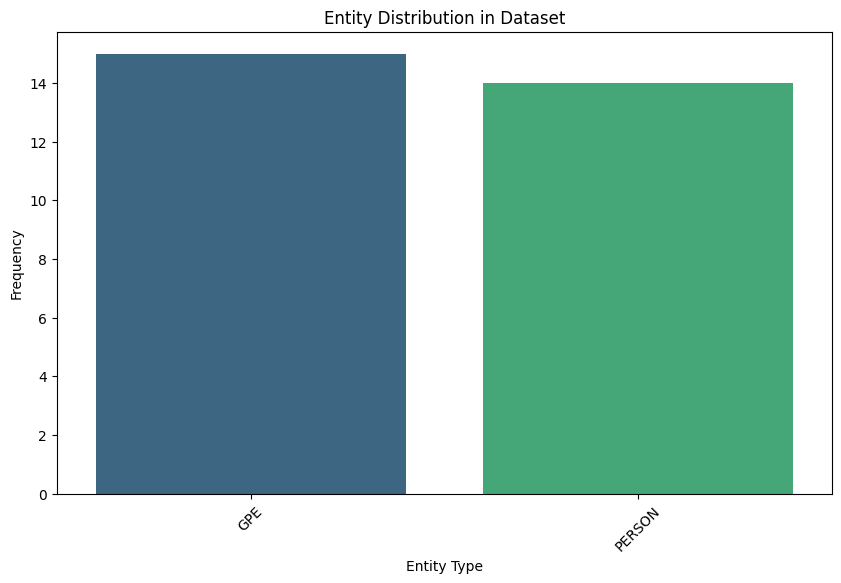

In [9]:
# Step 5: Visualization of Entities
def visualize_entities(data):
    """
    Visualizes the distribution of entities in the dataset.
    """
    all_entities = [ent[1] for entity_list in data['entities'] for ent in entity_list]
    entity_counts = pd.Series(all_entities).value_counts()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=entity_counts.index, y=entity_counts.values, palette='viridis')
    plt.title('Entity Distribution in Dataset')
    plt.xlabel('Entity Type')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

visualize_entities(data)

In [11]:
# Step 6: Save Results to a New CSV File
output_file_path = '/content/tweet_processed.csv'
data.to_csv(output_file_path, index=False)
print(f"Processed data saved to {output_file_path}")

# Display a preview of the processed data
print("Processed Data Preview:")
print(data[['text', 'cleaned_text', 'entities', 'summary', 'validated_summary']].head())

Processed data saved to /content/tweet_processed.csv
Processed Data Preview:
                                                text  \
0  I've avoided a hot take on the log4j situation...   
1  @RSnake Right? Whoever started calling it log4...   
2  @jobertabma @Hacker0x01 Please give insight fo...   
3  I was just talking about the impact of this vu...   
4  Is it me or did the Internet miss a golden opp...   

                                        cleaned_text entities  \
0  ive avoided a hot take on the log4j situation ...       []   
1  right whoever started calling it log4shell cle...       []   
2   please give insight for the rewarded log4j stats       []   
3  i was just talking about the impact of this vu...       []   
4  is it me or did the internet miss a golden opp...       []   

                                             summary  \
0  "I'm tired of tech hot takes," says the author...   
1  Right whoever started calling it log4shell cle...   
2  The rewarded log4j stats